In [2]:
import glob
import os
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectFromModel,RFECV
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.metrics import accuracy_score,r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas_ta as pta
import talib as ta
import pandas as pd
import datetime
from sklearn.feature_selection import SelectFromModel,RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.metrics import accuracy_score,r2_score

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split


In [3]:
#function to extract file name from the full path
def extract_filename(filepath):
    filename = os.path.basename(filepath)
    return filename

In [4]:
#creates a list of dataframes from all the csv files and skips the files with no data
folder_path = 'D://gitrepo/Stocks'
file_paths = glob.glob(folder_path + '\*.txt')
data = {}
skip_count=0
for file_path in file_paths:
    try:
        df = pd.read_csv(file_path, delimiter=',')
        if not df.empty:
            file_name=extract_filename(file_path)
            data[file_name]=df
    except pd.errors.EmptyDataError:
        skip_count+=1
print(f"Skipped empty file: ",skip_count)

Skipped empty file:  32


In [5]:
#testing
c=0
for i in data:
    print(i)
    print(data[i].head(2))
    c+=1
    if c>2:
        break 

a.us.txt
         Date    Open    High     Low   Close    Volume  OpenInt
0  1999-11-18  30.713  33.754  27.002  29.702  66277506        0
1  1999-11-19  28.986  29.027  26.872  27.257  16142920        0
aa.us.txt
         Date    Open    High     Low   Close  Volume  OpenInt
0  1970-01-02  2.2972  2.3178  2.2972  2.2972   26437        0
1  1970-01-05  2.2972  2.2972  2.2544  2.2759   29887        0
aaap.us.txt
         Date   Open   High   Low  Close   Volume  OpenInt
0  2015-11-11  18.50  25.90  18.0   24.5  1584600        0
1  2015-11-12  24.25  27.12  22.5   25.0    83000        0


In [6]:
#creating a temporary dataframe
temp_data=data['a.us.txt']

In [7]:
#momentum indicators
temp_data['Momentum']=pta.mom(temp_data['Close'])
temp_data['WILLR']=ta.WILLR(temp_data['High'],temp_data['Low'],temp_data['Close'],timeperiod=14)

stochio=pta.stoch(temp_data['High'],temp_data['Low'],temp_data['Close'])
temp_data=pd.concat([temp_data, stochio], axis=1)
temp_data['SMA 5'] = ta.SMA(temp_data['Close'], timeperiod=5)
temp_data['SMA 8'] = ta.SMA(temp_data['Close'], timeperiod=8)
temp_data['SMA 13'] = ta.SMA(temp_data['Close'], timeperiod=13)
temp_data['SMA 50'] = ta.SMA(temp_data['Close'], timeperiod=50)
temp_data['SMA 200'] = ta.SMA(temp_data['Close'], timeperiod=200)
temp_data['EMA 5'] = ta.EMA(temp_data['Close'], timeperiod=5)
temp_data['EMA 8'] = ta.EMA(temp_data['Close'], timeperiod=8)
temp_data['EMA 13'] = ta.EMA(temp_data['Close'], timeperiod=13)
temp_data['RSI1 14'] = ta.RSI(temp_data['Close'],timeperiod=14)
temp_data['CCI1 14'] = ta.CCI(temp_data['High'],temp_data['Low'],temp_data['Close'],timeperiod=14)




In [8]:
#cycle indicators
temp_data['HT DCPERIOD'] = ta.HT_DCPERIOD(temp_data['Close']) 
temp_data['HT DPCHASE'] = ta.HT_DCPHASE(temp_data['Close']) 
temp_data['inphase'], temp_data['quadrature'] = ta.HT_PHASOR(temp_data['Close']) 
temp_data['sine'], temp_data['leadsine'] = ta.HT_SINE(temp_data['Close']) 
temp_data['HT TRENDMODE'] = ta.HT_TRENDMODE(temp_data['Close']) 


In [9]:
#volatility indicators from talib
temp_data['TR'] = ta.TRANGE(temp_data['High'],temp_data['Low'],temp_data['Close'])
temp_data['ATR'] = ta.ATR(temp_data['High'],temp_data['Low'],temp_data['Close'],timeperiod=14) 


In [10]:
#volatility indicators from pandas_ta
#donchian
#temp_data['DCL'],temp_data['DCM'],temp_data['DCU']=pta.donchian(temp_data['High'],temp_data['Low'],offset=20)
donchian=pta.donchian(temp_data['High'],temp_data['Low'],offset=20)
temp_data=pd.concat([temp_data, donchian], axis=1)
#keltner
#temp_data['KCL'],temp_data['KCB'],temp_data['KCU']=pta.kc(temp_data['High'],temp_data['Low'],temp_data['Close'])
keltner=pta.kc(temp_data['High'],temp_data['Low'],temp_data['Close'])
temp_data=pd.concat([temp_data, keltner], axis=1)


In [11]:
end = temp_data.index[-1]

In [12]:
temp_data["SMA_HL"] = 0
for i in range(10,end):
    MA = 0
    for j in range(i-10,i):
        MA+=temp_data["High"][j]-temp_data["Low"][j]
    temp_data['SMA_HL'][i] = MA/10

C:\Users\ADITHYA\AppData\Local\Temp\ipykernel_20984\503040374.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_data['SMA_HL'][i] = MA/10


In [13]:
#Exponential moving average for High-Low
m = 0.0952
temp_data["EMA_HL"] = 0
temp_data["EMA_HL"][11] = (temp_data["High"][11]-temp_data["Low"][11])*m + temp_data["SMA_HL"][11]*(1-m)
for i in range(12,end):
    temp_data["EMA_HL"][i]= (temp_data["High"][i]-temp_data["Low"][i])*m + temp_data["EMA_HL"][i-1]*(1-m)

C:\Users\ADITHYA\AppData\Local\Temp\ipykernel_20984\2143315643.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_data["EMA_HL"][11] = (temp_data["High"][11]-temp_data["Low"][11])*m + temp_data["SMA_HL"][11]*(1-m)


In [14]:

temp_data["Chaikin"] = 0
for i in range(21,end):
    temp_data["Chaikin"][i] = (temp_data["EMA_HL"][i] - temp_data["EMA_HL"][i-10])/(temp_data["EMA_HL"][i-10]*100)

C:\Users\ADITHYA\AppData\Local\Temp\ipykernel_20984\264865425.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_data["Chaikin"][i] = (temp_data["EMA_HL"][i] - temp_data["EMA_HL"][i-10])/(temp_data["EMA_HL"][i-10]*100)


In [15]:
#trend indicators
supertrend=pta.supertrend(temp_data['High'],temp_data['Low'],temp_data['Close'])
temp_data=pd.concat([temp_data, supertrend], axis=1)
bbands=pta.bbands(temp_data['Close'])
temp_data=pd.concat([temp_data, bbands], axis=1)
macd=pta.macd(temp_data['Close'])
temp_data=pd.concat([temp_data, macd], axis=1)
adx=pta.adx(temp_data['High'],temp_data['Low'],temp_data['Close'])
temp_data=pd.concat([temp_data, adx], axis=1)
psar=pta.psar(temp_data['High'],temp_data['Low'],temp_data['Close'])
temp_data=pd.concat([temp_data, psar], axis=1)
test=pta.ichimoku(temp_data['High'],temp_data['Low'],temp_data['Close'])
temp_data=pd.concat([temp_data, test[0]], axis=1)



In [16]:
#volume indicators
temp_data['adosc']=pta.adosc(temp_data['High'],temp_data['Low'],temp_data['Close'],temp_data['Volume'])
temp_data['OBV']=ta.OBV(temp_data['Close'],temp_data['Volume'])
temp_data['MFI']=pta.mfi(temp_data['High'],temp_data['Low'],temp_data['Close'],temp_data['Volume'])
temp_data['PVOL']=pta.pvol(temp_data['Close'],temp_data['Volume'])
temp_data['CMF']=pta.cmf(temp_data['High'],temp_data['Low'],temp_data['Close'],temp_data['Volume'])



In [17]:
temp_data.head(5)

,Date,Open,High,Low,Close,Volume,OpenInt,Momentum,WILLR,STOCHk_14_3_3,...,ISA_9,ISB_26,ITS_9,IKS_26,ICS_26,adosc,OBV,MFI,PVOL,CMF
0,1999-11-18,30.713,33.754,27.002,29.702,66277506,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,41.514,NaN,66277506.0,NaN,1.968574e+09,NaN
1,1999-11-19,28.986,29.027,26.872,27.257,16142920,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,48.602,NaN,50134586.0,NaN,4.400076e+08,NaN
2,1999-11-22,27.886,29.702,27.044,29.702,6970266,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,53.497,NaN,57104852.0,NaN,2.070308e+08,NaN
3,1999-11-23,28.688,29.446,27.002,27.002,6332082,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,52.188,NaN,50772770.0,NaN,1.709789e+08,NaN
4,1999-11-24,27.083,28.309,27.002,27.717,5132147,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,48.602,NaN,55904917.0,NaN,1.422477e+08,NaN


Text(0.5, 0, 'Date')

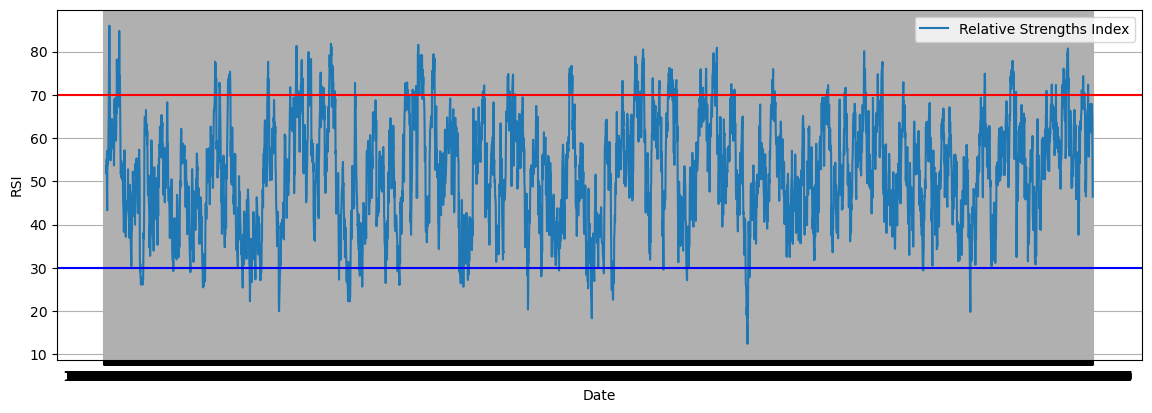

In [18]:
#RSI stock price bubble:The RSI values below 30 indicate that the stock price is oversold, and RSI values above 70 indicate the overbought levels. When the RSI indicator value reaches above 70, there is a high chance that stock price is falling. Due to overprice in stock
#RSI(#Days)D100􀀀(100=(1CAvg(Gain)=Avg(Loss)))
fig = plt.figure(figsize=(14,10))


ax2 = plt.subplot(2, 1, 2)
ax2=sns.lineplot(x=temp_data['Date'],y=temp_data['RSI1 14'], label='Relative Strengths Index')

ax2.axhline(y=70, color='red')
ax2.axhline(y=30, color='blue')
ax2.grid()
ax2.set_ylabel('RSI')
ax2.set_xlabel('Date')

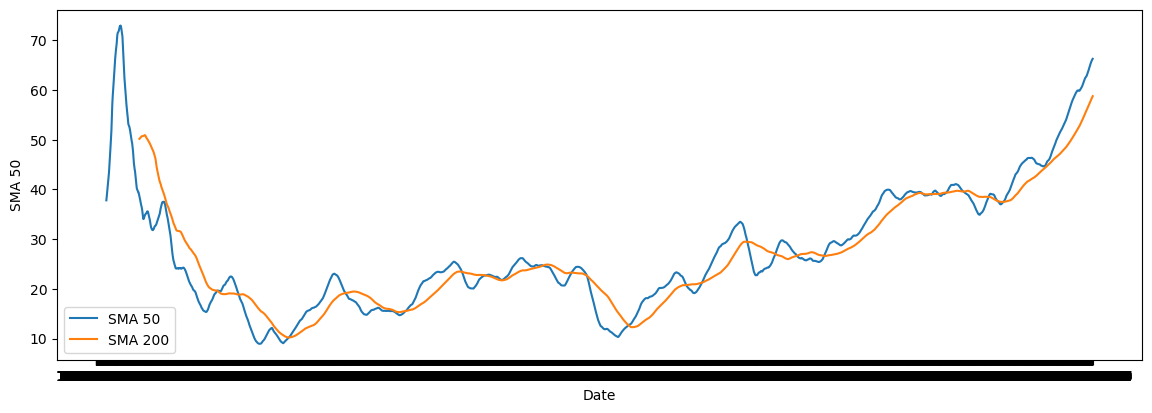

In [19]:
#DENTIFICATION OF STOCK CRISIS EVENTS USING MOVING AVERAGE STATISTICS
#The moving average is computed based on the stock price. The first moving average of 50 days indicates the stock price's short movements, and the second moving average of 200 days indicates long movements of the stock price. The short movements of stock price trades below its long price movements indicate the downtrend in stock price. Such data points are considered stock crisis starting points
fig = plt.figure(figsize=(14,10))


ax2 = plt.subplot(2, 1, 2)
ax2=sns.lineplot(x=temp_data['Date'],y=temp_data['SMA 50'], label='SMA 50')
ax2=sns.lineplot(x=temp_data['Date'],y=temp_data['SMA 200'], label='SMA 200')

In [20]:
column_headers = temp_data.columns.values.tolist()
print("The Column Header :", column_headers)

The Column Header : ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt', 'Momentum', 'WILLR', 'STOCHk_14_3_3', 'STOCHd_14_3_3', 'SMA 5', 'SMA 8', 'SMA 13', 'SMA 50', 'SMA 200', 'EMA 5', 'EMA 8', 'EMA 13', 'RSI1 14', 'CCI1 14', 'HT DCPERIOD', 'HT DPCHASE', 'inphase', 'quadrature', 'sine', 'leadsine', 'HT TRENDMODE', 'TR', 'ATR', 'DCL_20_20', 'DCM_20_20', 'DCU_20_20', 'KCLe_20_2', 'KCBe_20_2', 'KCUe_20_2', 'SMA_HL', 'EMA_HL', 'Chaikin', 'SUPERT_7_3.0', 'SUPERTd_7_3.0', 'SUPERTl_7_3.0', 'SUPERTs_7_3.0', 'BBL_5_2.0', 'BBM_5_2.0', 'BBU_5_2.0', 'BBB_5_2.0', 'BBP_5_2.0', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'ADX_14', 'DMP_14', 'DMN_14', 'PSARl_0.02_0.2', 'PSARs_0.02_0.2', 'PSARaf_0.02_0.2', 'PSARr_0.02_0.2', 'ISA_9', 'ISB_26', 'ITS_9', 'IKS_26', 'ICS_26', 'adosc', 'OBV', 'MFI', 'PVOL', 'CMF']


In [21]:
date = temp_data['Date'].to_numpy()
temp_data = temp_data.drop('Date', axis=1)

In [22]:
pd.set_option('display.max_columns', None)
pd.set_option("display.max_rows", None)

In [23]:
temp_data.isnull().values.any()
temp_data.isnull().sum()

Open                  0
High                  0
Low                   0
Close                 0
Volume                0
OpenInt               0
Momentum             10
WILLR                13
STOCHk_14_3_3        15
STOCHd_14_3_3        17
SMA 5                 4
SMA 8                 7
SMA 13               12
SMA 50               49
SMA 200             199
EMA 5                 4
EMA 8                 7
EMA 13               12
RSI1 14              14
CCI1 14              13
HT DCPERIOD          32
HT DPCHASE           63
inphase              32
quadrature           32
sine                 63
leadsine             63
HT TRENDMODE          0
TR                    1
ATR                  14
DCL_20_20            39
DCM_20_20            39
DCU_20_20            39
KCLe_20_2            20
KCBe_20_2            19
KCUe_20_2            20
SMA_HL                0
EMA_HL                0
Chaikin               0
SUPERT_7_3.0          6
SUPERTd_7_3.0         0
SUPERTl_7_3.0      2042
SUPERTs_7_3.0   

In [24]:
temp_data = temp_data.drop(['SUPERTl_7_3.0','SUPERTs_7_3.0','PSARl_0.02_0.2','PSARs_0.02_0.2'],axis=1)

In [25]:
temp_data=temp_data.dropna(axis=0, how='any')

In [26]:
temp_data.isnull().values.any()
temp_data.isnull().sum()

Open               0
High               0
Low                0
Close              0
Volume             0
OpenInt            0
Momentum           0
WILLR              0
STOCHk_14_3_3      0
STOCHd_14_3_3      0
SMA 5              0
SMA 8              0
SMA 13             0
SMA 50             0
SMA 200            0
EMA 5              0
EMA 8              0
EMA 13             0
RSI1 14            0
CCI1 14            0
HT DCPERIOD        0
HT DPCHASE         0
inphase            0
quadrature         0
sine               0
leadsine           0
HT TRENDMODE       0
TR                 0
ATR                0
DCL_20_20          0
DCM_20_20          0
DCU_20_20          0
KCLe_20_2          0
KCBe_20_2          0
KCUe_20_2          0
SMA_HL             0
EMA_HL             0
Chaikin            0
SUPERT_7_3.0       0
SUPERTd_7_3.0      0
BBL_5_2.0          0
BBM_5_2.0          0
BBU_5_2.0          0
BBB_5_2.0          0
BBP_5_2.0          0
MACD_12_26_9       0
MACDh_12_26_9      0
MACDs_12_26_9

In [27]:
temp_data.tail(10)

,Open,High,Low,Close,Volume,OpenInt,Momentum,WILLR,STOCHk_14_3_3,STOCHd_14_3_3,SMA 5,SMA 8,SMA 13,SMA 50,SMA 200,EMA 5,EMA 8,EMA 13,RSI1 14,CCI1 14,HT DCPERIOD,HT DPCHASE,inphase,quadrature,sine,leadsine,HT TRENDMODE,TR,ATR,DCL_20_20,DCM_20_20,DCU_20_20,KCLe_20_2,KCBe_20_2,KCUe_20_2,SMA_HL,EMA_HL,Chaikin,SUPERT_7_3.0,SUPERTd_7_3.0,BBL_5_2.0,BBM_5_2.0,BBU_5_2.0,BBB_5_2.0,BBP_5_2.0,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,ADX_14,DMP_14,DMN_14,PSARaf_0.02_0.2,PSARr_0.02_0.2,ISA_9,ISB_26,ITS_9,IKS_26,ICS_26,adosc,OBV,MFI,PVOL,CMF
4485,65.717,66.136,65.577,65.647,1185191,0,0.759,-25.360668,80.321438,85.040233,65.8744,65.756500,65.577615,62.34468,55.259715,65.769542,65.676677,65.350714,65.242292,44.241346,36.018545,187.337780,0.280077,-0.141736,-0.127719,-0.791627,1,0.559,0.743645,58.102,60.6695,63.237,63.373992,64.784640,66.195288,0.6407,0.674557,-0.001767,63.976215,1,65.595475,65.8744,66.153325,0.846840,0.092364,1.106770,-0.085441,1.192211,35.422030,29.253239,14.322856,0.02,0,60.19800,59.9840,65.6715,63.2365,67.49,1.132675e+05,513372379.0,66.461913,7.780423e+07,0.150290
4486,65.667,65.767,64.310,64.599,1845570,0,-1.377,-71.649269,60.981501,75.677250,65.6050,65.668000,65.579154,62.40876,55.359910,65.379361,65.437193,65.243326,53.127494,-97.518014,36.659480,189.463019,0.366281,0.287291,-0.164411,-0.813741,1,1.457,0.794599,58.102,60.6695,63.237,63.213136,64.766960,66.320785,0.6118,0.749045,-0.000899,63.976215,1,64.563506,65.6050,66.646494,3.175043,0.017040,0.958809,-0.186721,1.145531,33.121797,25.421839,23.836334,0.04,0,60.19800,59.9840,65.3125,63.2365,68.03,-3.881248e+05,511526809.0,63.377528,1.192220e+08,0.108544
4487,64.519,64.769,63.781,63.980,1618616,0,-2.026,-92.146803,36.947753,59.416897,65.1938,65.472125,65.500077,62.45986,55.453000,64.912907,65.113372,65.062851,47.515279,-198.100950,36.330084,196.710549,0.597599,-0.195323,-0.287537,-0.880565,1,0.988,0.808413,58.102,60.7740,63.446,63.097980,64.692012,66.286043,0.6717,0.771794,-0.000292,63.976215,1,63.653586,65.1938,66.734014,4.725031,0.105964,0.782580,-0.290360,1.072941,31.220365,23.202608,26.429571,0.06,0,60.19800,59.9840,65.0480,63.5760,68.02,-8.655047e+05,509908193.0,56.853313,1.035591e+08,0.044480
4488,64.140,64.529,63.920,64.260,1263271,0,-1.047,-81.097080,18.368949,38.766068,64.8546,65.276375,65.451769,62.52334,55.545015,64.695272,64.923734,64.948158,50.083943,-162.964731,35.332685,205.230938,0.415502,-1.971308,-0.426268,-0.941064,1,0.609,0.794170,58.102,60.8015,63.501,63.092648,64.650868,66.209087,0.7176,0.756296,-0.000502,63.976215,1,63.390066,64.8546,66.319134,4.516360,0.297000,0.657927,-0.332011,0.989938,29.454750,21.931704,24.981913,0.06,0,60.19800,59.9840,65.0480,64.0200,68.13,-9.352531e+05,511171464.0,57.207350,8.117779e+07,0.026482
4489,64.120,64.489,63.840,63.850,1079027,0,-1.697,-97.277032,9.826361,21.714355,64.4672,65.014375,65.288231,62.57522,55.635775,64.413514,64.685127,64.791278,46.495578,-148.114878,34.099391,212.860798,-0.148784,-2.786180,-0.542600,-0.977640,0,0.649,0.783800,58.102,60.9515,63.801,63.041158,64.574595,66.108031,0.6977,0.746081,-0.000531,66.419702,-1,63.180178,64.4672,65.754222,3.992795,0.260222,0.520060,-0.375902,0.895962,27.923767,20.634574,24.233429,0.06,0,60.49700,60.2830,65.0480,64.2695,68.37,-1.211510e+06,510092437.0,50.945084,6.889587e+07,-0.044484
4490,63.870,64.145,63.591,64.070,1676210,0,-1.756,-82.415565,13.070108,13.755139,64.1518,64.768625,65.139308,62.63948,55.726400,64.299010,64.548432,64.688238,48.622702,-123.863807,34.315734,217.603361,-0.696555,-3.205772,-0.610192,-0.991679,1,0.554,0.767386,58.102,61.4005,64.699,63.033619,64.526538,66.019457,0.6917,0.727795,-0.000441,66.038459,-1,63.631043,64.1518,64.672557,1.623515,0.421460,0.423668,-0.377836,0.801504,26.841485,19.570520,25.301497,0.08,0,60.78675,60.4555,64.9530,64.2695,68.22,-8.254535e+05,511768647.0,42.531852,1.073948e+08,-0.053955
4491,64.290,65.070,64.290,64.870,1693854,0,-1.076,-53.046990,22.420138,15.105536,64.2060,64.632875,65.105692,62.71196,55.822260,64.489340,6

In [28]:
column_headers = temp_data.columns.values.tolist()

print("The Column Header :", column_headers)

The Column Header : ['Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt', 'Momentum', 'WILLR', 'STOCHk_14_3_3', 'STOCHd_14_3_3', 'SMA 5', 'SMA 8', 'SMA 13', 'SMA 50', 'SMA 200', 'EMA 5', 'EMA 8', 'EMA 13', 'RSI1 14', 'CCI1 14', 'HT DCPERIOD', 'HT DPCHASE', 'inphase', 'quadrature', 'sine', 'leadsine', 'HT TRENDMODE', 'TR', 'ATR', 'DCL_20_20', 'DCM_20_20', 'DCU_20_20', 'KCLe_20_2', 'KCBe_20_2', 'KCUe_20_2', 'SMA_HL', 'EMA_HL', 'Chaikin', 'SUPERT_7_3.0', 'SUPERTd_7_3.0', 'BBL_5_2.0', 'BBM_5_2.0', 'BBU_5_2.0', 'BBB_5_2.0', 'BBP_5_2.0', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'ADX_14', 'DMP_14', 'DMN_14', 'PSARaf_0.02_0.2', 'PSARr_0.02_0.2', 'ISA_9', 'ISB_26', 'ITS_9', 'IKS_26', 'ICS_26', 'adosc', 'OBV', 'MFI', 'PVOL', 'CMF']


In [29]:
X = temp_data[['Open', 'High', 'Low', 'Volume', 'OpenInt', 'Momentum', 'WILLR', 'STOCHk_14_3_3', 'STOCHd_14_3_3', 'SMA 5', 'SMA 8', 'SMA 13', 'EMA 5', 'EMA 8', 'EMA 13', 'RSI1 14', 'CCI1 14', 'HT DCPERIOD', 'HT DPCHASE', 'inphase', 'quadrature', 'sine', 'leadsine', 'HT TRENDMODE', 'TR', 'ATR', 'DCL_20_20', 'DCM_20_20', 'DCU_20_20', 'KCLe_20_2', 'KCBe_20_2', 'KCUe_20_2', 'SMA_HL', 'EMA_HL', 'Chaikin', 'SUPERT_7_3.0', 'SUPERTd_7_3.0', 'BBL_5_2.0', 'BBM_5_2.0', 'BBU_5_2.0', 'BBB_5_2.0', 'BBP_5_2.0', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'ADX_14', 'DMP_14', 'DMN_14', 'PSARaf_0.02_0.2', 'PSARr_0.02_0.2', 'ISA_9', 'ISB_26', 'ITS_9', 'IKS_26', 'ICS_26', 'adosc', 'OBV', 'MFI', 'PVOL', 'CMF']]
y = temp_data['Close']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


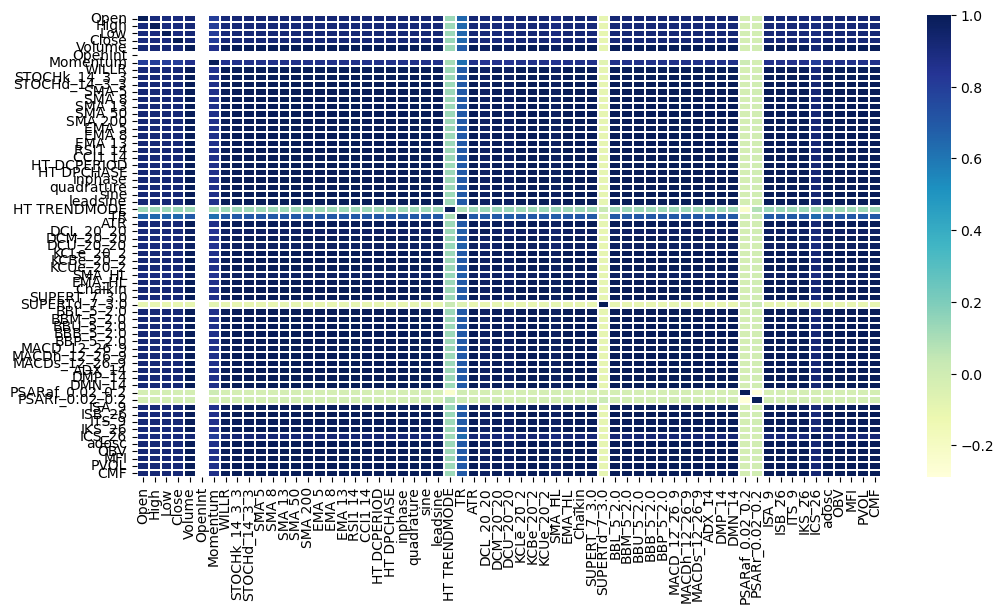

In [30]:
plt.figure(figsize=(12, 6))

corr = temp_data.apply(lambda x: pd.factorize(x)[0]).corr()
ax = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns,linewidths=.2, cmap="YlGnBu")

In [31]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)

In [32]:

from xgboost import XGBRegressor
from sklearn import metrics
model = XGBRegressor(n_estimators=100, subsample=0.9, colsample_bynode=0.2)
model.fit(X_train, y_train)
preds = model.predict(X_test)


In [33]:
mae = metrics.mean_absolute_error(y_test, preds)
mse = metrics.mean_squared_error(y_test, preds)
rmse = np.sqrt(mse) # or mse**(0.5)  
print("Results of sklearn.metrics:")
print("MAE:",mae)
print("MSE:", mse)
print("RMSE:", rmse)




Results of sklearn.metrics:
MAE: 1207.8034076499275
MSE: 2008249.8664068866
RMSE: 1417.1273289323321


In [34]:
from sklearn.model_selection import GridSearchCV
PARAMETERS = {"subsample":[0.5, 0.75, 1],
"colsample_bytree":[0.5, 0.75, 1],
"max_depth":[2, 6, 12],
"min_child_weight":[1,5,15],
"learning_rate":[0.3, 0.1, 0.03],
"n_estimators":[100,150,200],  "max_depth": [3, 18, 1],
        "gamma":[1,9],
        "reg_alpha":[0,1,5],
        "reg_lambda": [0,1,5]}

In [ ]:
model_gs = GridSearchCV(model,param_grid=PARAMETERS,cv=3,scoring="accuracy")
eval_set = [(X_train, y_train),(X_test,y_test)]
model_gs.fit(X_train,y_train,early_stopping_rounds=10, eval_metric="error",eval_set=eval_set,verbose=0)
print(model_gs.bestparams)
predictions = model_gs.predict(X_test)
print('Accuracy:',accuracy_score(y_test, predictions))